In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mosqlient import get_predictions

import seaborn as sns
import dataframe_image as dfi
from itertools import product
import matplotlib.dates as mdates

plt.rcParams.update({'font.size': 14})

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_cases(data, state):
    data_ = data.loc[data.uf == state]
    
    data_.loc[:, 'date']  = pd.to_datetime(data_.date)

    data_ = data_.rename(columns = {'date':'dates'})

    data_.set_index('dates', inplace = True)
    
    return data_

Fetch the predictions from the API: 

%%time
for model_id in [21, 22, 25,26, 27, 28, 29, 30]:

    list_of_preds = get_predictions(model_id = model_id)

    for idx in np.arange(0, len(list_of_preds)): 

        df = list_of_preds[idx].to_dataframe()
        state = df.adm_1.unique()[0]

        if state in ['AM', 'CE', 'GO', 'PR', 'MG']:
            year = pd.to_datetime(df.dates).dt.year.max()
            if model_id == 26:
                
                model_id_ = 25
            else:
                model_id_ = model_id
                
            df.to_csv(f'./predictions/preds_{model_id_}_{state}_{year}.csv.gz',index = False)


### Make the panel

In [3]:
data = pd.read_csv('data/dengue_uf.csv.gz')

data.head()

,uf,date,casos
0,AC,2010-01-03,869
1,AC,2010-01-10,1003
2,AC,2010-01-17,1010
3,AC,2010-01-24,1397
4,AC,2010-01-31,2000


In [4]:
data.date.min()

'2010-01-03'

In [5]:
data.date.max()

'2024-06-02'

In [6]:
def make_comp_plot(ci = False): 
    custom_lines = [Line2D([0], [0], color='black', marker='s', linestyle='None', markersize=10)]

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    model_ids = [21, 22, 25, 27, 28, 29, 30]
    
    model_legend = ['Data', 'Dobby data', 'Global Health Resilience', 
                    'GeoHealth', 'Ki-Dengu Peppa model 1', 'Ki-Dengu Peppa model 2',
                   'DS_OKSTATE', 'BB-M']
    
    for c in colors: 
    
        custom_lines.append(Line2D([0], [0], color=c, marker='s', linestyle='None', markersize=10))

    fig, axs  = plt.subplots(5,2, figsize = (15, 25))
        
    ax =axs.ravel()
        
    i = 0
    
    for state,year in product(['AM','CE', 'GO', 'PR', 'MG'],
                        [2023, 2024]):
        start_date = Week(year-1, 41).startdate().strftime('%Y-%m-%d')
    
        if year==2024:
            end_date = '2024-06-02'
        else:
            end_date= Week(year, 40).startdate().strftime('%Y-%m-%d')
        data_ = get_cases(data, state)
        data_ = data_.loc[(data_.index >= pd.to_datetime(start_date)) & (data_.index <= pd.to_datetime(end_date))]
        
        ax[i].plot(data_.casos, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
        
        for model_id, color in zip(model_ids,
                                   colors):
        
            preds = pd.read_csv(f'./predictions/preds_{model_id}_{state}_{year}.csv.gz')
            preds.dates = pd.to_datetime(preds.dates)
            preds.set_index('dates', inplace = True)
            preds = preds.loc[(preds.index >= pd.to_datetime(start_date)) & (preds.index <= pd.to_datetime(end_date))]
            
            ax[i].plot(preds.preds, color = color, linewidth = 1.5)

            if ci: 
                ax[i].fill_between(preds.index, preds.lower, preds.upper, color = color, alpha = 0.1)
    
        ax[i].set_title(f'{state} - {year}')
    
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
        
        # Rotate the date labels for better readability
        fig.autofmt_xdate(rotation=0, ha='center')
    
        if year == 2023:
            ax[i].set_ylabel('New cases')
    
        i= i+1
    
    ax[1].legend(custom_lines, model_legend, title ='Model', bbox_to_anchor=(1, 0.525, 0.1, 0.5))
    
    plt.subplots_adjust(wspace = 0.15,)

    if ci: 
        plt.savefig('figures/comp_preds_ci.png', dpi = 600, bbox_inches = 'tight')
    else:
        plt.savefig('figures/comp_preds.png', dpi = 600, bbox_inches = 'tight')
    
    plt.show()

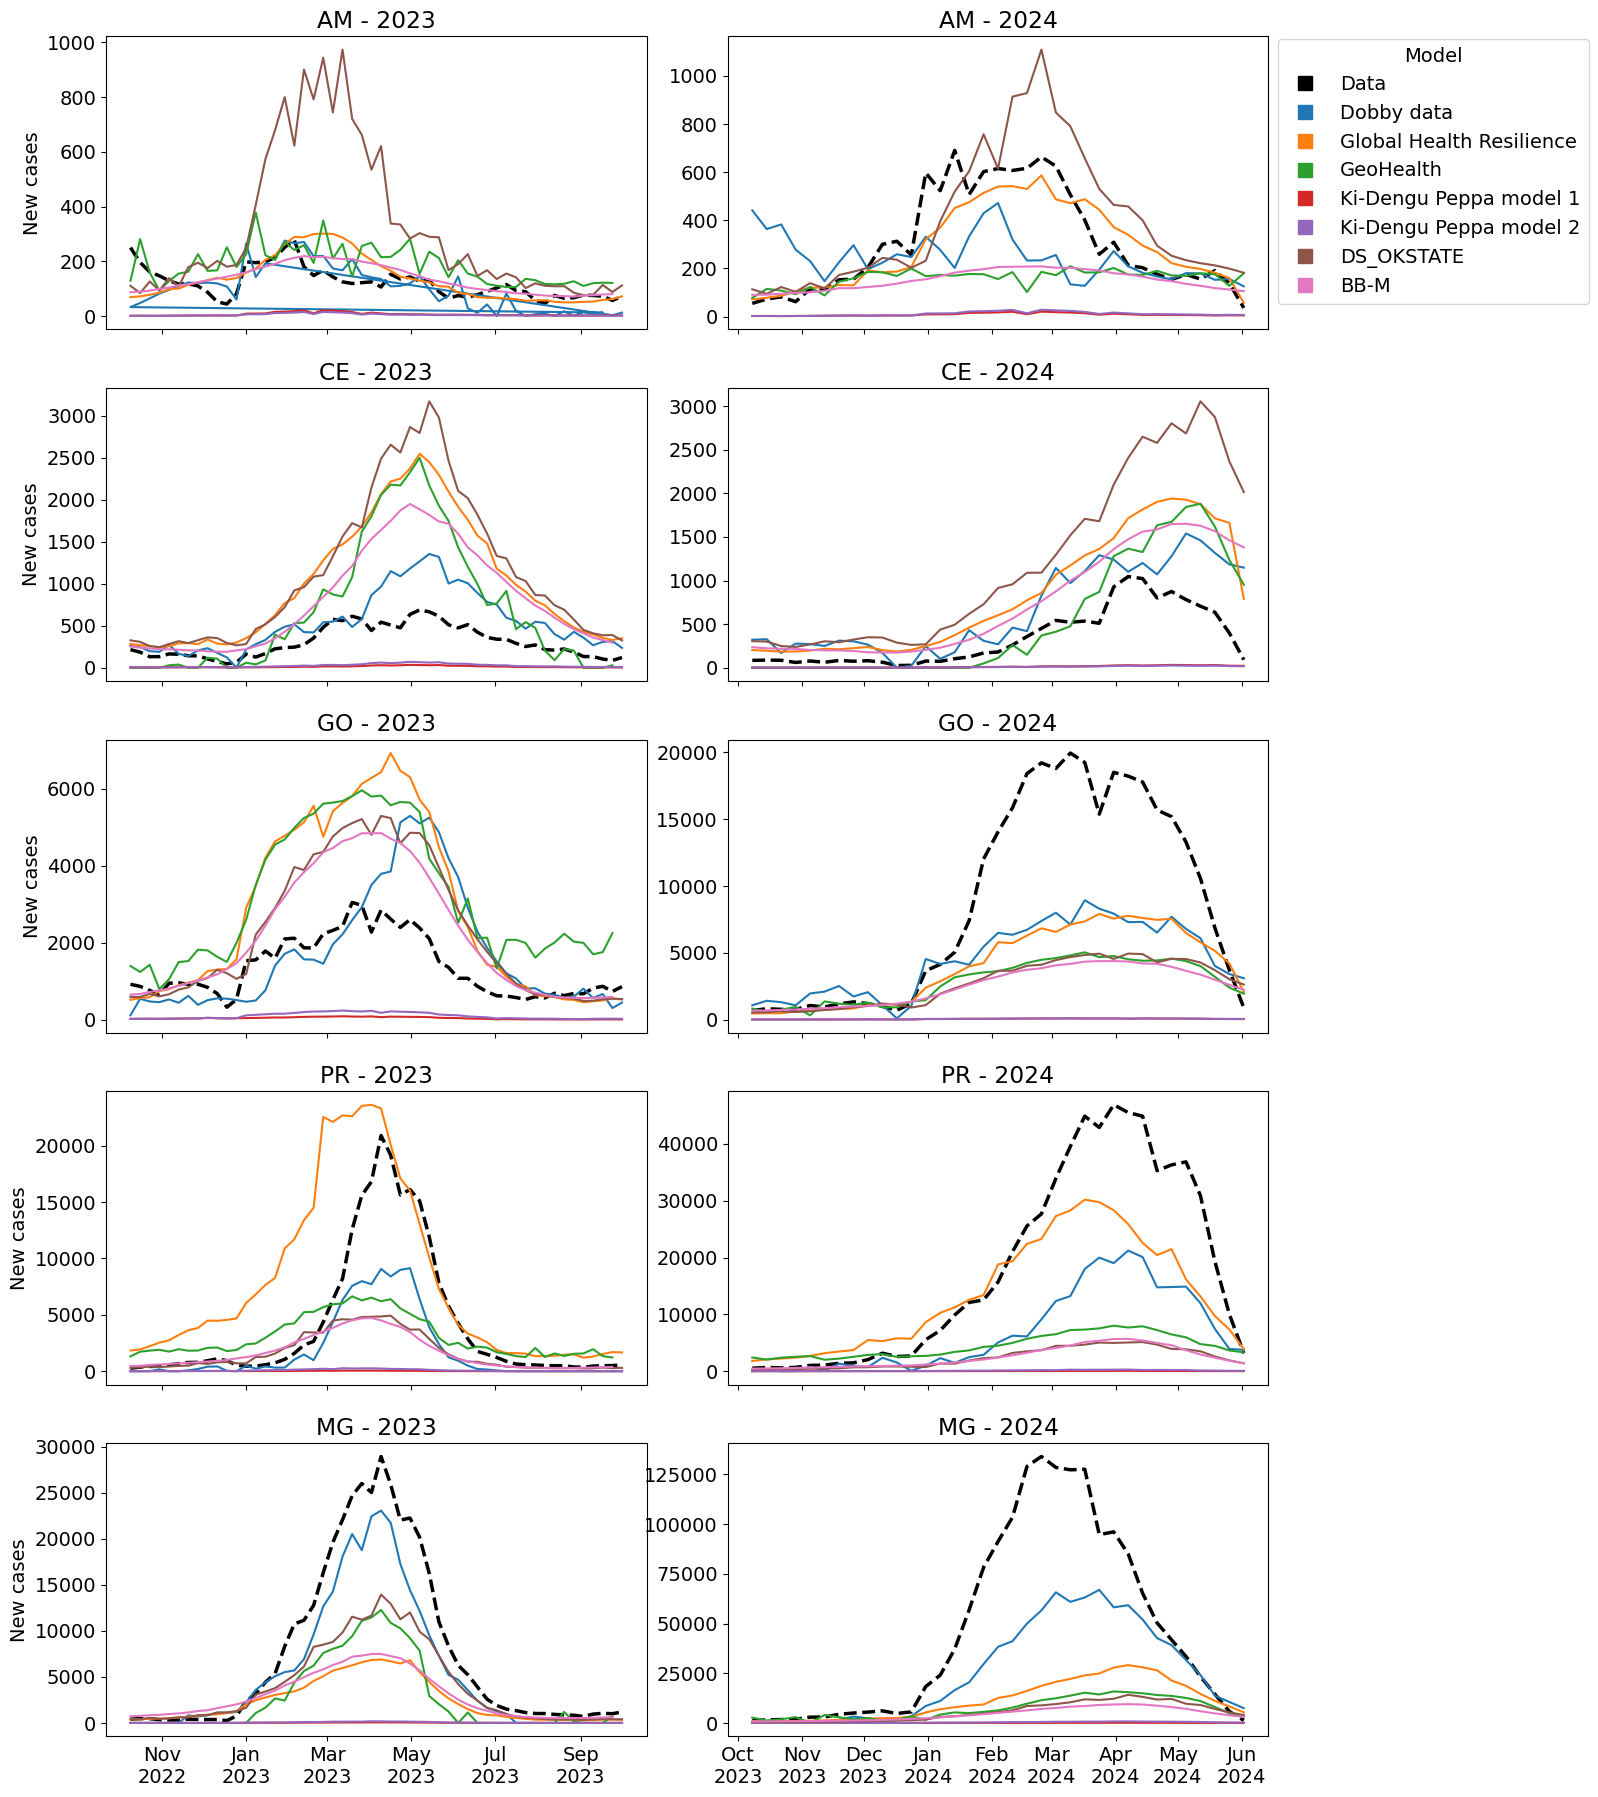

In [7]:
make_comp_plot(ci = False)

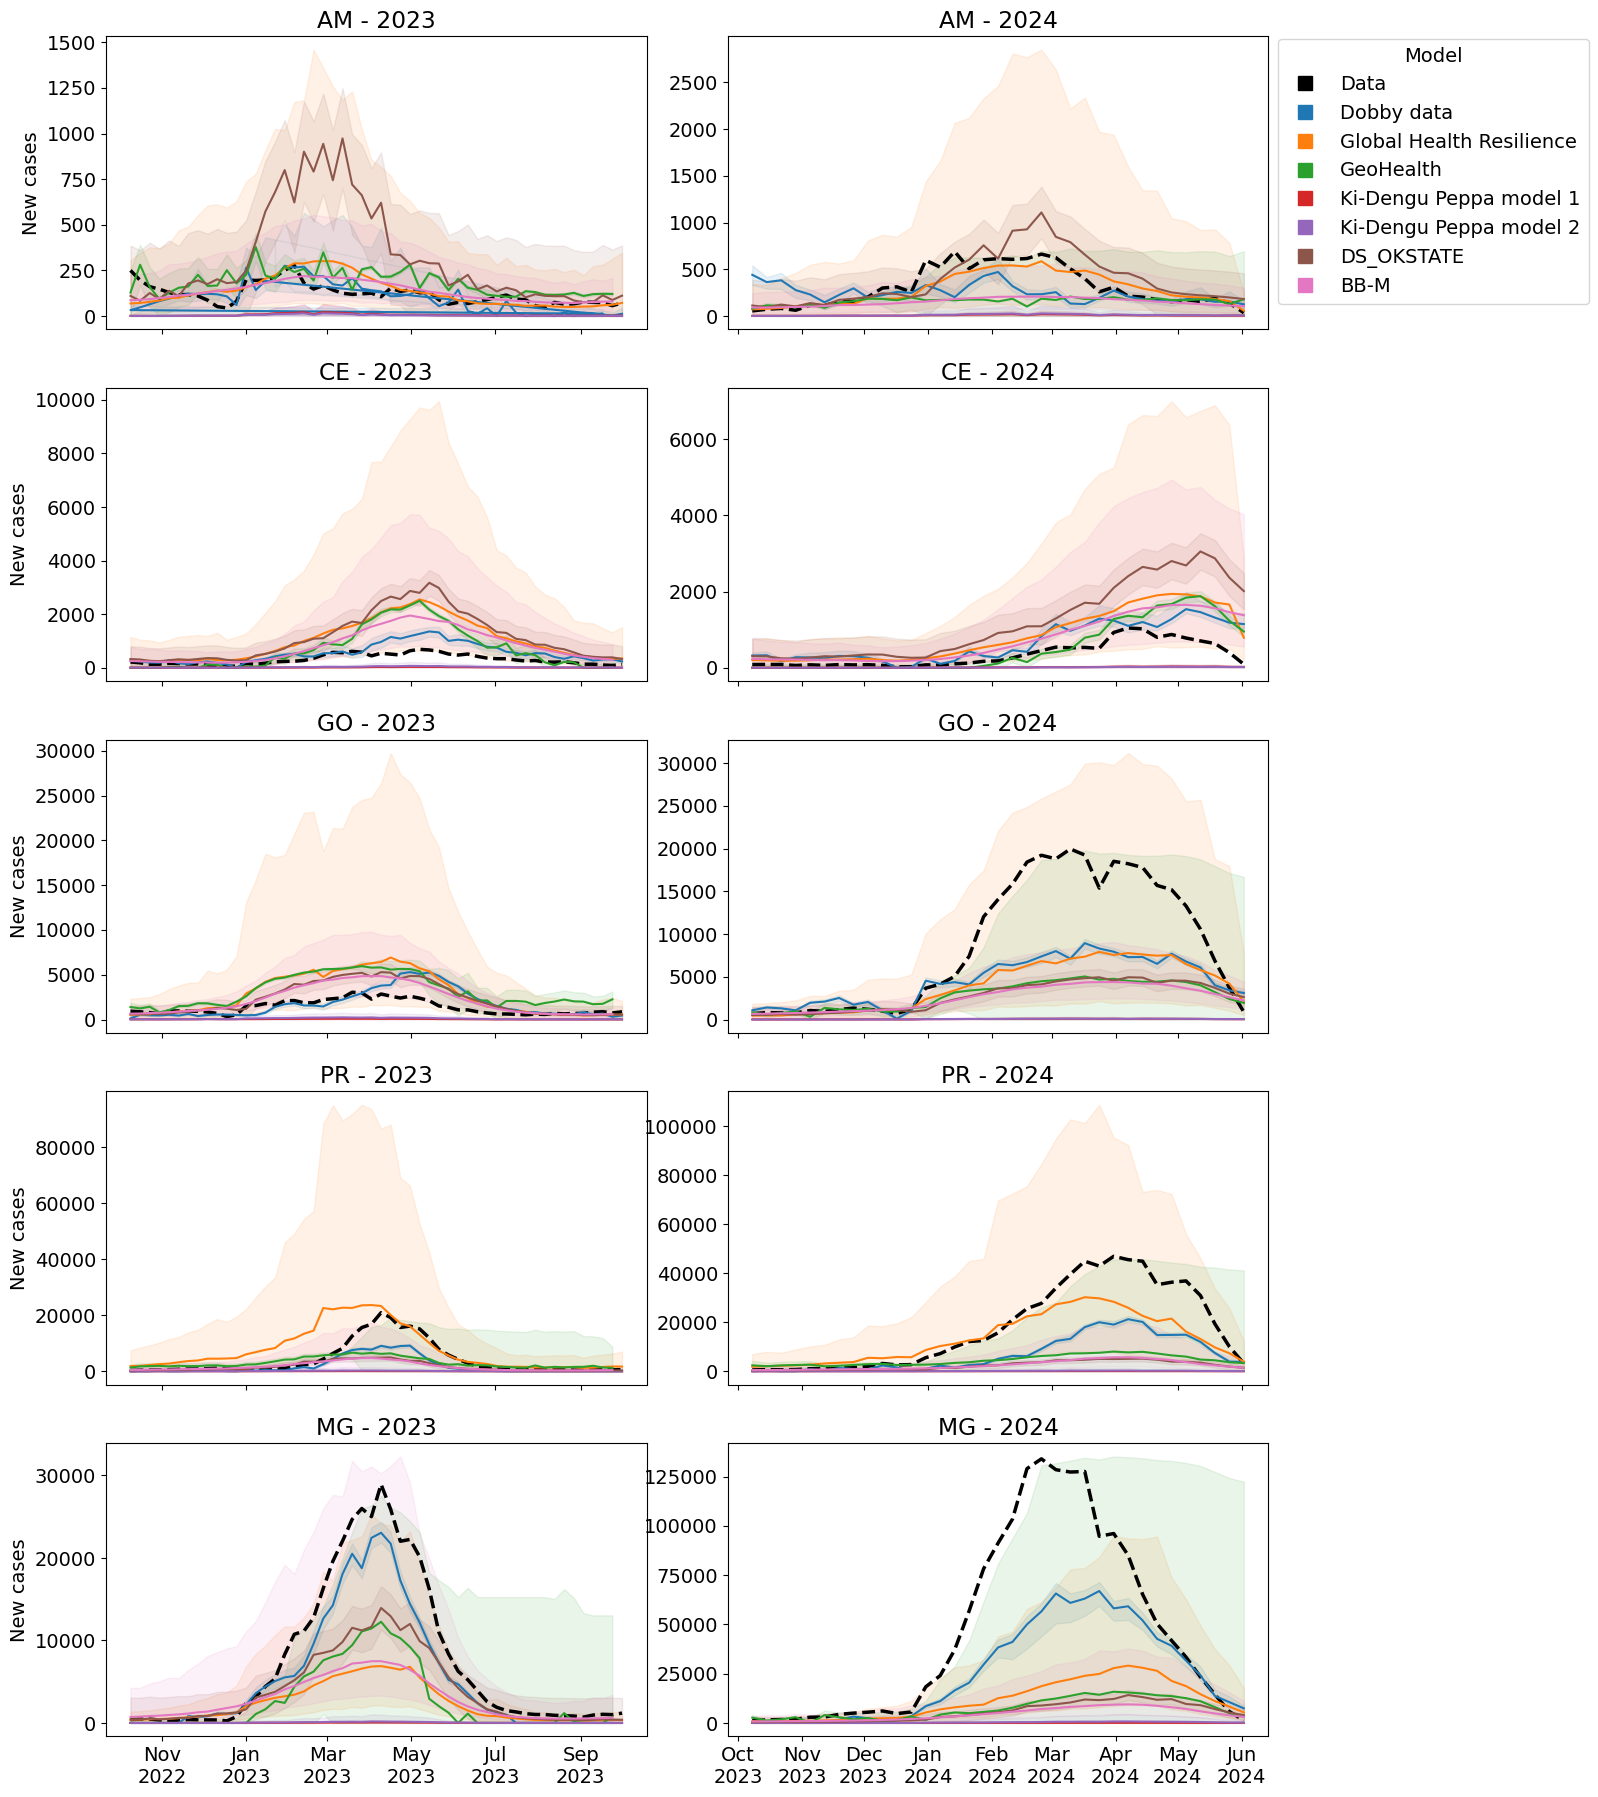

In [8]:
make_comp_plot(ci = True)

### Computing the increase rate between the peaks in 2023 and 2024

In [9]:
def taxa_aumento(valor_inicial, valor_final):
    taxa_aumento = ((valor_final - valor_inicial) / valor_inicial) * 100
    return taxa_aumento

In [10]:
df_peaks = pd.DataFrame()

for state,year in product(['AM','CE', 'GO', 'PR', 'MG'],
                        [2023, 2024]):
    
    df_aux = pd.DataFrame()
    peaks = []
    start_date = Week(year-1, 41).startdate().strftime('%Y-%m-%d')
    
    if year==2024:
        end_date = '2024-06-02'
    else:
        end_date= Week(year, 40).startdate().strftime('%Y-%m-%d')
    data_ = get_cases(data, state)
    data_ = data_.loc[(data_.index >= pd.to_datetime(start_date)) & (data_.index <= pd.to_datetime(end_date))]

    peaks.append(data_.casos.max())
    
    model_ids = [21, 22, 25, 27, 28, 29, 30]
    
    for model_id in model_ids:
            
        preds = pd.read_csv(f'./predictions/preds_{model_id}_{state}_{year}.csv.gz')
        preds.dates = pd.to_datetime(preds.dates)
        preds.set_index('dates', inplace = True)
        preds = preds.loc[(preds.index >= pd.to_datetime(start_date)) & (preds.index <= pd.to_datetime(end_date))]

        peaks.append(preds.preds.max())

    df_aux['model'] = ['Data'] + model_ids
    df_aux['peaks'] = peaks
    df_aux['year'] = year
    df_aux['state'] = state

    df_peaks = pd.concat([df_peaks, df_aux])


In [11]:
df_peaks

,model,peaks,year,state
0,Data,277.000000,2023,AM
1,21,275.583288,2023,AM
2,22,301.000000,2023,AM
3,25,378.000000,2023,AM
4,27,21.384251,2023,AM
...,...,...,...,...
3,25,15847.000000,2024,MG
4,27,78.389248,2024,MG
5,28,775.409240,2024,MG
6,29,14152.560000,2024,MG


In [12]:
df_piv = pd.pivot_table(df_peaks, values='peaks', index=['model', 'state'],
                       columns=['year'])

df_piv['rate'] = taxa_aumento(df_piv[2023].values, df_piv[2024].values)
df_piv.head()

year                 2023          2024        rate
model state                                        
21    AM       275.583288    471.683268   71.158154
      CE      1355.299519   1539.066182   13.559118
      GO      5289.631832   8936.444941   68.942664
      MG     23054.132027  66931.601057  190.323665
      PR      9140.712802  21218.929163  132.136482

In [13]:
df_piv_2 = df_piv.reset_index()

df_piv_2 = pd.pivot_table(df_piv_2, values = 'rate', index = 'model', columns = 'state')

df_piv_2

state,AM,CE,GO,MG,PR
model,,,,,
21,71.158154,13.559118,68.942664,190.323665,132.136482
22,94.850498,-23.896410,14.334224,322.104499,27.713367
25,-44.708995,-24.830068,-15.415617,29.226127,20.686540
27,-3.769865,-5.037934,-1.323789,23.821021,21.230214
28,87.007892,-62.625242,-59.008248,326.440742,11.075475
29,13.942115,-3.761896,-6.511718,1.541552,3.927169
30,-4.794521,-15.384615,-9.500207,26.038189,20.421119
Data,149.097473,51.669086,555.551905,363.118778,124.172566


In [14]:
cm = sns.color_palette('coolwarm', as_cmap=True)

rename_models = {30: 'BB-M', 21: 'Dobby data', 25: 'GeoHealth', 
                22: 'Global Health Resilience', 29: 'DS_OKSTATE',
                27: 'Ki-Dengu Peppa model 1', 
                28: 'Ki-Dengu Peppa model 2'}

df_piv_2 = df_piv_2.rename(index=rename_models)

df_piv_2 = df_piv_2.loc[['Data', 'BB-M', 'GeoHealth', 'Dobby data', 'DS_OKSTATE',
       'Ki-Dengu Peppa model 1', 'Ki-Dengu Peppa model 2',
       'Global Health Resilience']]

df_piv_2 = df_piv_2.style.background_gradient(cmap=cm, vmin = -200, vmax = 200)

dfi.export(df_piv_2, f'./figures/increase_rate.png')


In [15]:
df_piv_2

state,AM,CE,GO,MG,PR
model,,,,,
Data,149.097473,51.669086,555.551905,363.118778,124.172566
BB-M,-4.794521,-15.384615,-9.500207,26.038189,20.421119
GeoHealth,-44.708995,-24.830068,-15.415617,29.226127,20.686540
Dobby data,71.158154,13.559118,68.942664,190.323665,132.136482
DS_OKSTATE,13.942115,-3.761896,-6.511718,1.541552,3.927169
Ki-Dengu Peppa model 1,-3.769865,-5.037934,-1.323789,23.821021,21.230214
Ki-Dengu Peppa model 2,87.007892,-62.625242,-59.008248,326.440742,11.075475
Global Health Resilience,94.850498,-23.896410,14.334224,322.104499,27.713367
